In [1]:
import math
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import convolve2d
from math import comb
import concurrent.futures
from copy import deepcopy
import cv2
from scipy.ndimage import maximum_filter


In [2]:

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array


def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Function '{func.__name__}' took {duration:.6f} seconds to run.")
        return result

    return wrapper


def expand_image(img, expanded_size, kernel_size=5, ratio=2):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / (weights / 4)
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0] * ratio:ratio, :img.shape[1] * ratio:ratio] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


# create a function that returns the gaussian kernel for a given size and the total sum of the kernel
# for example ofr size=5 return kernel = np.array([[1, 4, 6, 4, 1],
# [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]]) and weight = 256
def get_gaussian_kernel(size):
    # Calculate the kernel
    n = math.floor(size)
    kernel = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            kernel[i, j] = comb(n - 1, i) * comb(n - 1, j)

    # Normalize the kernel to make the sum an integer
    kernel_sum = np.sum(kernel)
    kernel_factor = int(np.ceil(kernel_sum))
    kernel = (kernel * kernel_factor / kernel_sum).astype(int)

    return kernel, kernel_factor


def reduce_image(img, reduced_img_size, kernel_size=5, should_blur=True):
    # Create the gaussian kernel
    (kernel, weights) = get_gaussian_kernel(kernel_size)
    kernel = kernel / weights
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))

    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]

    return reduced_img


def get_reduced_size(img, factor=2):
    return (img.shape[0] // factor, img.shape[1] // factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1]))) - 1


# @measure_time
def create_pyramid(img, kernel_size=5):
    pyramid = []
    pyramid.append({'G': img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size, kernel_size)
        expanded_image_size = pyramid[i - 1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size, kernel_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})

    for i in range(len(pyramid) - 1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i + 1]['Expanded_G']
    pyramid[-1]['L'] = pyramid[-1]['G']
    return pyramid


def plot_gaussian_pyramid(pyramid, levels=None):
    if levels is None:
        levels = range(len(pyramid))
    plt.subplots(1, len(levels), figsize=(20, 20))
    for index, level in enumerate(levels):
        plt.subplot(1, len(levels), index + 1)
        plt.imshow(pyramid[level]['G'], cmap="gray")
        plt.title(f"Level {level}")
    plt.show()


def plot_expanded_gaussian_pyramid(pyramid):
    plt.subplots(1, (len(pyramid) - 1), figsize=(20, 20))
    for i in range(len(pyramid) - 1):
        plt.subplot(1, len(pyramid) - 1, i + 1)
        plt.imshow(pyramid[i + 1]['Expanded_G'], cmap="gray")
        plt.title(f"Level {i + 1} Expanded")
    plt.show()


def plot_laplacian_pyramid(pyramid, levels=None):
    if levels is None:
        levels = range(len(pyramid))
    plt.subplots(1, len(levels), figsize=(20, 20))
    for index, level in enumerate(levels):
        plt.subplot(1, len(levels), index + 1)
        plt.imshow(pyramid[level]['L'], cmap="gray")
        plt.title(f"Level {level}")
    plt.show()


def get_mask_pyramid(mask):
    mask = np.ceil(mask / 255)
    mask_pyramid = []
    mask_pyramid.append({'G': mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid


def reconstruct_image(pyramid):
    reconstructed_img = pyramid[-1]['L']
    for i in range(len(pyramid) - 2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_pyramids(pyramid1, pyramid2, mask_pyramid, max_level=100):
    blended_pyramid = []
    i = 0
    max_level = min(max_level, len(pyramid1))
    for i in range(max_level - 1):
        blended_pyramid.append(
            {'L': pyramid1[i]['L'] * mask_pyramid[i]['G'] + (1 - mask_pyramid[i]['G']) * pyramid2[i]['L']})
    # the last level is blended differently
    blended_pyramid.append(
        {'L': pyramid1[i + 1]['G'] * mask_pyramid[i + 1]['G'] + (1 - mask_pyramid[i + 1]['G']) * pyramid2[i + 1]['G']})
    return blended_pyramid


def rgb_to_yiq(img):
    # Conversion matrix from RGB to YIQ
    conversion_matrix = np.array([[0.299, 0.587, 0.114],
                                  [0.595716, -0.274453, -0.321263],
                                  [0.211456, -0.522591, 0.311135]])
    # Apply the conversion matrix
    yiq_image = np.dot(img.astype(float), conversion_matrix.T)

    # Clip values to [0, 255] range and convert to integers
    yiq_image = np.clip(yiq_image, 0, 255).astype(int)

    return yiq_image


def yiq_to_rgb(img_array):
    # Conversion matrix from YIQ to RGB
    conversion_matrix = np.array([[1, 0.9663, 0.6210],
                                  [1, -0.2721, -0.6474],
                                  [1, -1.1070, 1.7046]])

    # Apply the conversion matrix
    rgb_image = np.dot(img_array.astype(float), conversion_matrix.T)

    # Clip values to [0, 255] range and convert to integers
    rgb_image = np.clip(rgb_image, 0, 255).astype(int)

    return rgb_image


# the method opens an image based on its path and return 3 matrices in Y, I and Q color spaces
def open_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    return rgb_to_yiq(img_array)

    
def blend_images(img1, img2, mask, max_level, kernel_size=5):
    with (concurrent.futures.ThreadPoolExecutor() as executor):
        img1_pyramid_a, img1_pyramid_b, img1_pyramid_c = create_pyramid(img1[:, :, 0], kernel_size), create_pyramid(
            img1[:, :, 1], kernel_size), create_pyramid(img1[:, :, 2], kernel_size)
        img2_pyramid_a, img2_pyramid_b, img2_pyramid_c = create_pyramid(img2[:, :, 0], kernel_size), create_pyramid(
            img2[:, :, 1], kernel_size), create_pyramid(img2[:, :, 2], kernel_size)
        mask_pyramid = get_mask_pyramid(mask)
        blended_pyramid_a = blend_pyramids(img1_pyramid_a, img2_pyramid_a, mask_pyramid, max_level)
        blended_pyramid_b = blend_pyramids(img1_pyramid_b, img2_pyramid_b, mask_pyramid, max_level)
        blended_pyramid_c = blend_pyramids(img1_pyramid_c, img2_pyramid_c, mask_pyramid, max_level)
    return yiq_to_rgb(np.dstack((reconstruct_image(blended_pyramid_a), reconstruct_image(blended_pyramid_b),
                                 reconstruct_image(blended_pyramid_c))))


def q1(img_1_path, img_2_path, mask_path, kernel_size=5, max_level=100):
    img1 = open_image(img_1_path)
    img2 = open_image(img_2_path)
    mask = get_gray_img_mat(mask_path)
    blended_img = blend_images(img1, img2, mask, max_level, kernel_size)
    return blended_img


def blend_pyramids_based_on_level(pyramid1, pyramid2, max_level_1):
    blended_pyramid = []
    for i in range(max_level_1):
        blended_pyramid.append({'L': pyramid1[i]['L']})
    for i in range(max_level_1, len(pyramid1)):
        blended_pyramid.append({'L': pyramid2[i]['L']})
    return blended_pyramid


def q2(img_1_path, img_2_path, kernel_size=5, level=2):
    img_1 = get_gray_img_mat(img_1_path)
    img_2 = get_gray_img_mat(img_2_path)
    pyramid1 = create_pyramid(img_1, kernel_size)
    pyramid2 = create_pyramid(img_2, kernel_size)
    blended_pyramid = blend_pyramids_based_on_level(pyramid1, pyramid2, level)
    reconstructed_img = reconstruct_image(blended_pyramid)
    return reconstructed_img



In [5]:
def cv2_open_image(img_path):
    img = cv2.imread(img_path)
    return img

def cv2_get_gray_img_mat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [261]:
# implementing Harris corner detection
def harris_corner_detection(gray_img, harris_window_size, k, threshold, suppression_window_size):
    img_gaussian = cv2.GaussianBlur(gray_img,(3,3),0)

    Ix = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)

    Ix2=np.square(Ix)
    Iy2=np.square(Iy)
    Ixy=Ix*Iy

    harris_window = np.ones((harris_window_size, harris_window_size))
    Sx2 = convolve2d(Ix2, harris_window, mode='same')
    Sy2 = convolve2d(Iy2, harris_window, mode='same')
    Sxy = convolve2d(Ixy, harris_window, mode='same')

    det = Sx2 * Sy2 - (Sxy ** 2)
    trace = Sx2 + Sy2

    R = det - k * (trace ** 2)
    cv2.normalize(R, R, 0, 1, cv2.NORM_MINMAX)
    R[R < threshold] = 0     
    
    return R

# Suppress non-maximum responses
def non_maximum_suppression(corners, suppression_window_size):
    # Apply maximum filter for non-maximum suppression
    suppressed_corners = corners * (corners == maximum_filter(corners, footprint=np.ones((suppression_window_size, suppression_window_size))))
    return suppressed_corners


# def remove_corners_with_zero_std(corners, window_size):
#     # Pad the corners array to handle border cases
#     padded_corners = np.pad(corners, window_size // 2, mode='constant')
#     
#     # Define a kernel for computing the sum of squares of the window
#     kernel = np.ones((window_size, window_size))
#     
#     # Compute the local standard deviation using convolution
#     squared_sum = convolve2d(padded_corners**2, kernel, mode='valid')
#     sum_squared = convolve2d(padded_corners, kernel, mode='valid')**2 / (window_size**2)
#     
#     # Set corners with zero standard deviation to zero
#     corners_with_std = np.where(squared_sum == sum_squared, corners, 0)
# 
#     return corners_with_std



# create multiscale Harris corner detector
def multiscale_harris_corner_detector(pyramid, scales, harris_window_size, k, threshold, suppression_window_size):
    # Initialize corners tensor
    corners_arr = np.zeros((scales,), dtype=np.ndarray)
    # Iterate over the scales in the pyramid 
    for scale in range(scales):
        # Perform the Harris corner detection
        corners = harris_corner_detection(pyramid[scale]['G'], harris_window_size, k, threshold, suppression_window_size)     
        # Add the corners to the corners tensor
        corners_arr[scale] = corners
    return corners_arr





In [260]:
threshold = 0.3
harris_window_size = 5
k = 0.04
suppression_window_size = 0
scales = 2



img_low_res_path = './assets/desert_low_res.jpg'
img_high_res_path = './assets/desert_high_res.png'
######## main ########

    
img_low_res = cv2_open_image(img_low_res_path)
img_high_res = cv2_open_image(img_high_res_path)
img_low_res_gray = cv2_get_gray_img_mat(img_low_res)
img_high_res_gray = cv2_get_gray_img_mat(img_high_res)
low_pyramid = create_pyramid(img_low_res_gray, harris_window_size)
high_pyramid = create_pyramid(img_high_res_gray, harris_window_size)
corners_arr_low = multiscale_harris_corner_detector(low_pyramid, scales, harris_window_size, k, threshold, suppression_window_size)
corners_arr_high = multiscale_harris_corner_detector(high_pyramid, scales, harris_window_size, k, threshold, suppression_window_size)

#remove corners from the low res image in the scale 0 
corners_arr_low[0] = np.zeros(corners_arr_low[0].shape)

#TODO ransac


In [254]:
print('img_high_res shape:', img_high_res.shape, 'corners_arr_high shape:', corners_arr_high[0].shape)

img_high_res shape: (1280, 1920, 3) corners_arr_high shape: (1280, 1920)


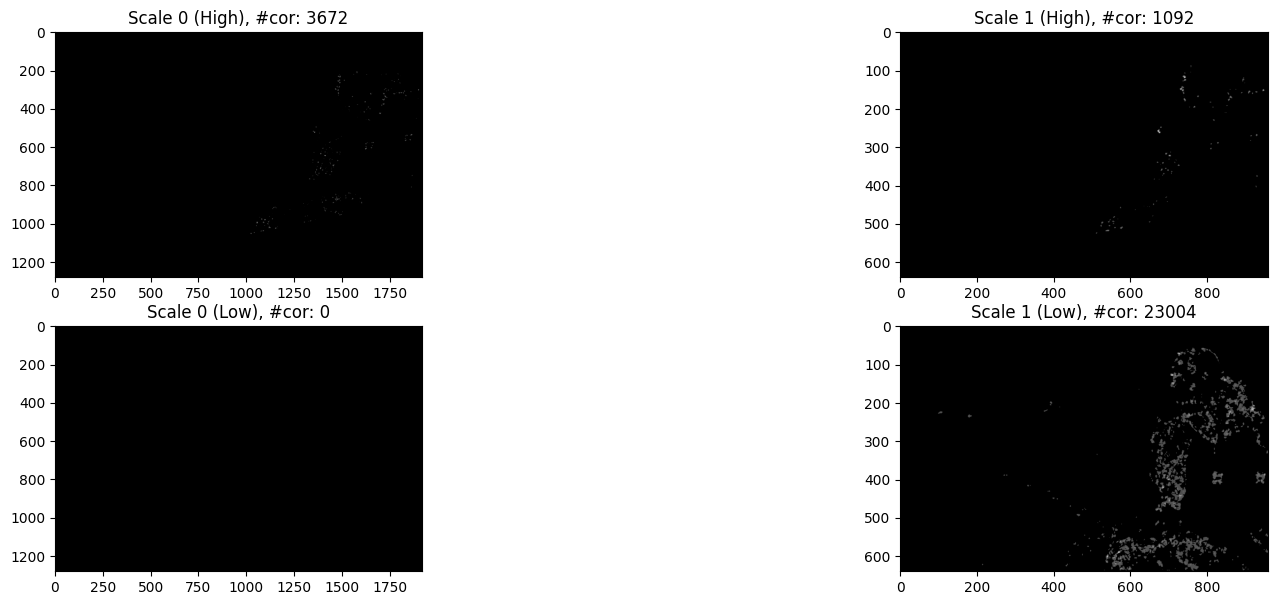

In [262]:

# iterate over the scales and plot the corners
fig, axes = plt.subplots(2, scales, figsize=(20, 7))
for i in range(scales):
    # Plot corners for high
    axes[0, i].imshow(corners_arr_high[i], cmap='gray')
    axes[0, i].set_title(f"Scale {i} (High), #cor: {np.sum(corners_arr_high[i] != 0)}")
    # Plot corners for low
    axes[1, i].imshow(corners_arr_low[i], cmap='gray')
    axes[1, i].set_title(f"Scale {i} (Low), #cor: {np.sum(corners_arr_low[i] != 0)}")

plt.show()



In [285]:

def backward_warping_window(x, y, theta, img, window_size):
    output_img = np.zeros((window_size, window_size))
    for i in range(window_size):
        for j in range(window_size):
            # Translate the coordinates to be relative to the center of the window
            x_rel, y_rel = i - window_size // 2, j - window_size // 2
            # Apply rotation transformation
            x_rot = int(x_rel * math.cos(theta) - y_rel * math.sin(theta)) + x
            y_rot = int(x_rel * math.sin(theta) + y_rel * math.cos(theta)) + y
            
            # Ensure the rotated coordinates are within the bounds of the original image
            if 0 <= x_rot < img.shape[0] and 0 <= y_rot < img.shape[1]:
                # Perform bilinear interpolation
                x0, y0 = int(x_rot), int(y_rot)
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = x_rot - x0, y_rot - y0
                try:
                    output_img[i, j] = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x0, y1] + (1 - dx) * dy * img[x1, y0] + dx * dy * img[x1, y1]
                except IndexError:
                    continue
                
    return output_img

# normalize the corners windows (I = I - mean(I)/ std(I))
def normalize_window(window):
    normalized_window = window - np.mean(window)
    if np.std(window) != 0:
        normalized_window = normalized_window / np.std(window)
    return normalized_window


def get_mops_descriptor(x, y, theta, img, window_size):
    # Perform backward warping
    warped_window = backward_warping_window(x, y, theta, img, window_size)
    # Normalize the window
    descriptor = normalize_window(warped_window)
    return descriptor


def get_mops_descriptors(pyramid, corners_arr, descriptor_window_size, scale_added_to_get_descriptor):
    descriptors = []
    for scale in range(scales):
        img_in_scale = pyramid[scale]['G']
        img_in_2_scales_above = pyramid[scale+scale_added_to_get_descriptor]['G']
        corners = corners_arr[scale]
        # calculate the gradient of the image at the current scale
        Ix = cv2.Sobel(img_in_scale, cv2.CV_64F, 1, 0, ksize=3)
        Iy = cv2.Sobel(img_in_scale, cv2.CV_64F, 0, 1, ksize=3)
        # Iterate over the corners
        for x, y in zip(*np.where(corners != 0)):
            # extract the angle of the corner by the gradient of the image
            theta = math.atan2(Iy[x, y], Ix[x, y])
            x_in_higher_scale, y_in_higher_scale = get_coordinated_in_higher_scale(x, y, scale_added_to_get_descriptor)
            # Perform backward warping on the scale+2
            descriptor = get_mops_descriptor(x_in_higher_scale, y_in_higher_scale, theta, img_in_2_scales_above, descriptor_window_size)
            # Compute the difference between the original and warped windows
            descriptors.append([x, y, scale, theta, descriptor]) 
    return descriptors


def get_coordinated_in_higher_scale(x, y, scale_added):
    return x // (2 ** scale_added), y // (2 ** scale_added)



descriptor_window_size = 8
scale_added_to_get_descriptor = 2
matches_ratio_threshold = 1


descriptors_low = get_mops_descriptors(low_pyramid, corners_arr_low, descriptor_window_size, scale_added_to_get_descriptor)
descriptors_high = get_mops_descriptors(high_pyramid, corners_arr_high, descriptor_window_size, scale_added_to_get_descriptor)


(1280, 1920)

In [289]:

# create a function that returns the euclidean distance between two descriptors
def euclidean_distance(descriptor1, descriptor2):
    return np.linalg.norm(descriptor1 - descriptor2)

def get_best_match(descriptor, descriptors):
    # Extract descriptors from the list
    all_descriptors = np.array([d[4] for d in descriptors])
    
    # Calculate the Euclidean distances
    distances = np.linalg.norm(all_descriptors - descriptor[4], axis=(1,2))
    
    # Find the index of the best match
    best_match_idx = np.argmin(distances)
    
    # Remove the best match from the distances to find the second best match
    distances[best_match_idx] = np.inf
    second_best_match_idx = np.argmin(distances)
    
    # Get the best and second best matches
    best_match = descriptors[best_match_idx]
    second_best_match = descriptors[second_best_match_idx]
    
    return best_match, second_best_match



# create a function that returns the best matches for each descriptor
def get_best_matches(descriptors1, descriptors2, ratio_threshold):
    matches = []
    for i, d in enumerate(descriptors1):
        best_match, second_best_match = get_best_match(d, descriptors2)
        if best_match is not None and second_best_match is not None:
            NN_1 = euclidean_distance(d[4], best_match[4])
            NN_2 = euclidean_distance(d[4], second_best_match[4])
            # if not NN_1 or not NN_2 or NN_2 == 0 or NN_1 / NN_2 > ratio_threshold:
            #     continue
            matches.append([d, best_match, NN_1])
    matches.sort(key=lambda x: x[2])
    return matches


matches = get_best_matches(descriptors_high, descriptors_low, matches_ratio_threshold)


first match descriptor: 387 1706 0 -0.4860319293400963
second match descriptor: 253 854 1 -0.42862150843023394


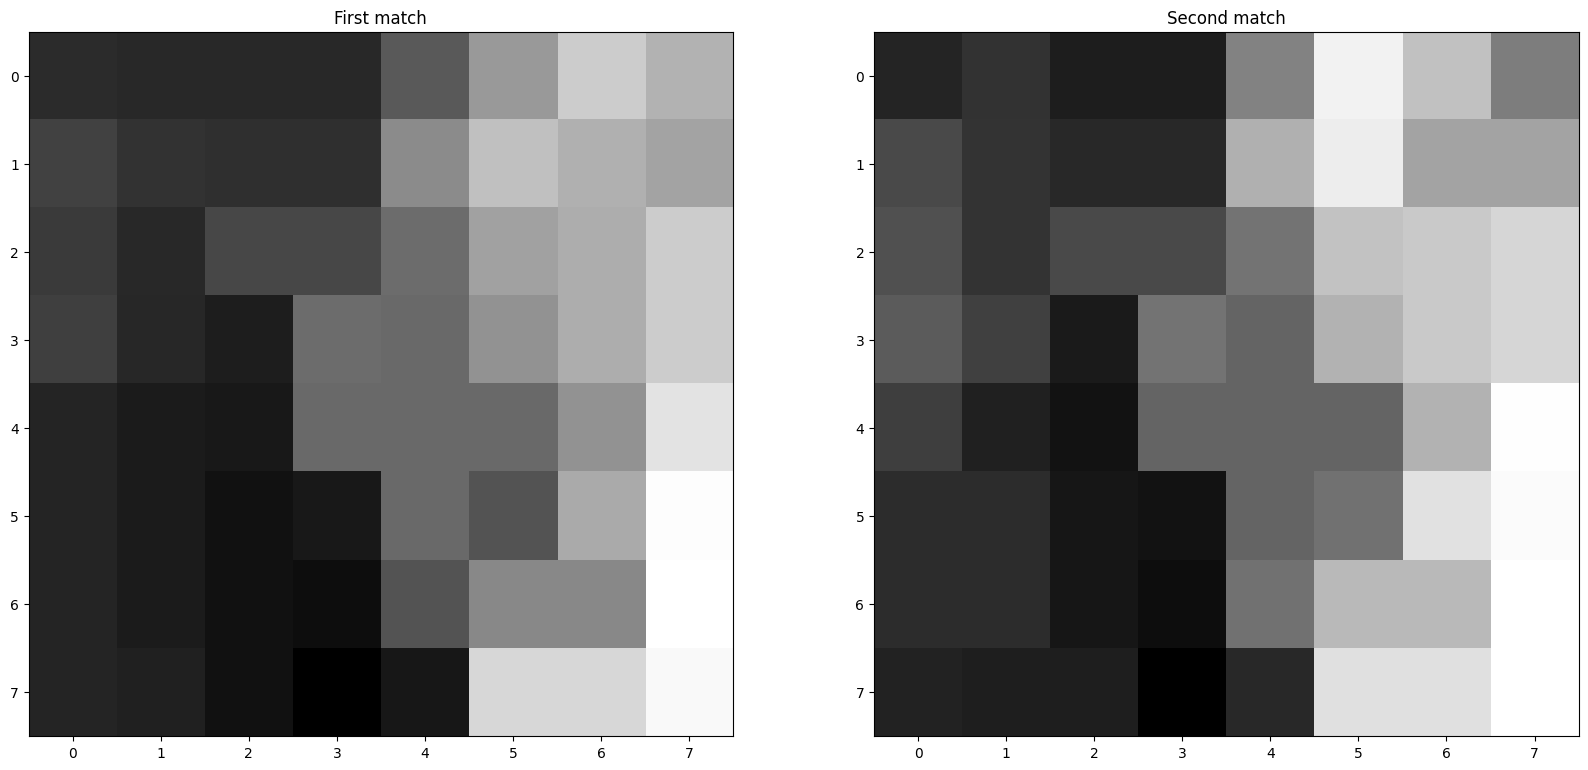

In [290]:
# plot the matches for i index in the matches list and print the descriptors of the first match
i = 103
print('first match descriptor:', matches[i][0][0], matches[i][0][1], matches[i][0][2], matches[i][0][3])
print('second match descriptor:', matches[i][1][0], matches[i][1][1], matches[i][1][2], matches[i][1][3])
# plot the matches next to each other
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(matches[i][0][4], cmap='gray')
axes[0].set_title('First match')
axes[1].imshow(matches[i][1][4], cmap='gray')
axes[1].set_title('Second match')
plt.show()




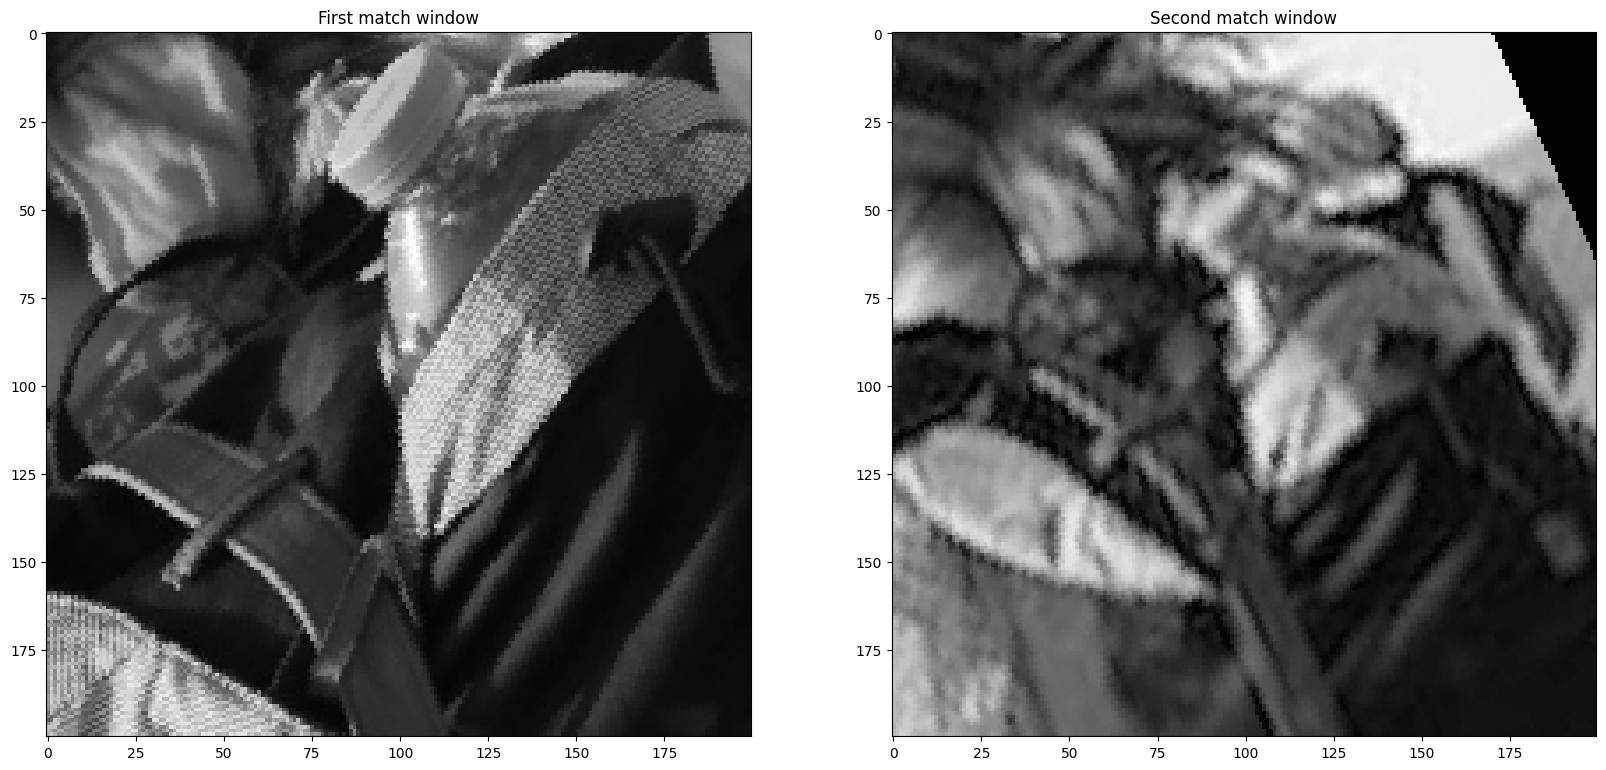

In [291]:
# show windows of the first match for each corner by using the x, y, scale and theta of the first match (show the windows next to each other)
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
x, y, scale, theta, descriptor = matches[i][0]
window = backward_warping_window(x, y, theta, high_pyramid[scale]['G'], 200)
axes[0].imshow(window, cmap='gray')
axes[0].set_title('First match window')
x, y, scale, theta, descriptor = matches[i][1]
window = backward_warping_window(x, y, theta, low_pyramid[scale]['G'], 200)
axes[1].imshow(window, cmap='gray')
axes[1].set_title('Second match window')
plt.show()


In [292]:

# implement RANSAC algorithm - each iteration, randomly select 4 matches and calculate the homography matrix
# then, calculate the number of inliers for each match and select the best homography matrix
# finally, return the best homography matrix
def ransac(matches, iterations, threshold):
    best_homography = None
    best_inliers = 0
    best_inliers_matches = []
    for iter in range(iterations):
        # Randomly select 4 indexes from the matches
        random_indexes = np.random.choice(len(matches), 4, replace=False)
        random_matches = [matches[i] for i in random_indexes]
        # Calculate the homography matrix
        H = calculate_homography(random_matches)
        # Calculate the number of inliers
        inliers = 0
        inliers_matches = []
        for match in matches:
            # Apply the transformation to the point
            x, y = match[0][0], match[0][1]
            x_prime, y_prime = get_original_coordinates(match[1])
            
            p = np.array([x, y, 1])
            p_prime = np.dot(H, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Calculate the distance between the transformed point and the second point
            distance = np.linalg.norm(p_prime - np.array([x_prime, y_prime]))
            # If the distance is less than the threshold, increment the number of inliers
            if distance < threshold:
                inliers += 1
                inliers_matches.append(match)
        # If the current homography matrix has more inliers than the best one, update the best one
        if inliers > best_inliers:
            best_inliers = inliers
            best_inliers_matches = inliers_matches
            best_homography = H
        if iter % 100 == 0:
            print(f'iteration {iter}, best inliers: {best_inliers}')
    return best_homography, best_inliers_matches


        
# function for calculating the homography matrix using cv2.findHomography
def calculate_homography(matches):
    
    src_pts = np.array([[get_original_coordinates(match[0])] for match in matches])
    dst_pts = np.array([[get_original_coordinates(match[1])] for match in matches])
    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return H


# create a function that based on the scale of a descriptor, returns the original coordinates of the descriptor
def get_original_coordinates(descriptor):
    return descriptor[0] * (2 ** descriptor[2]), descriptor[1] * (2 ** descriptor[2])





In [293]:
best_H, inliers = ransac(matches, 2000, 10)

iteration 0, best inliers: 16
iteration 100, best inliers: 48
iteration 200, best inliers: 105
iteration 300, best inliers: 105
iteration 400, best inliers: 105
iteration 500, best inliers: 105
iteration 600, best inliers: 105


/var/folders/_7/xf1wjsfx5bs9p2klwbsmtf640000gq/T/ipykernel_50034/2299462363.py:24: RuntimeWarning: invalid value encountered in divide
  p_prime = (p_prime / p_prime[2])[:2]


iteration 700, best inliers: 105
iteration 800, best inliers: 105
iteration 900, best inliers: 209
iteration 1000, best inliers: 209
iteration 1100, best inliers: 209
iteration 1200, best inliers: 209
iteration 1300, best inliers: 209
iteration 1400, best inliers: 209
iteration 1500, best inliers: 209
iteration 1600, best inliers: 209
iteration 1700, best inliers: 209
iteration 1800, best inliers: 209
iteration 1900, best inliers: 209


In [294]:
H = calculate_homography(inliers)

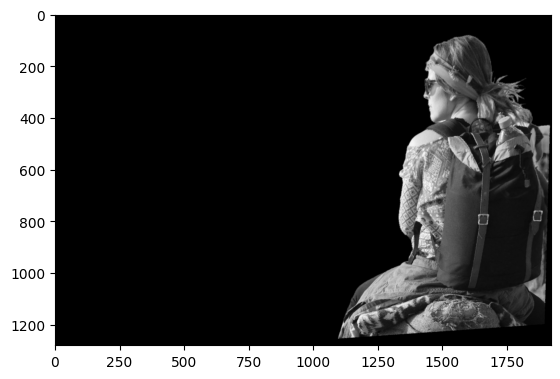

In [295]:
# implement the function that returns the transformed image using the homography matrix
def transform_image(img, H):
    # Create the inverse transformation matrix
    H_inv = np.linalg.inv(H)
    # Create the output image
    output_img = np.zeros_like(img)
    # Iterate over the pixels in the output image
    for i in range(output_img.shape[0]):
        for j in range(output_img.shape[1]):
            # Apply the inverse transformation to the pixel coordinates
            p = np.array([i, j, 1])
            p_prime = np.dot(H_inv, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Check if the transformed pixel is within the bounds of the input image
            if 0 <= p_prime[0] < img.shape[0] and 0 <= p_prime[1] < img.shape[1]:
                # Perform bilinear interpolation
                x0, y0 = int(p_prime[0]), int(p_prime[1])
                x1, y1 = min(x0 + 1, img.shape[0]-1) , min(y0 + 1, img.shape[1]-1)
                dx, dy = p_prime[0] - x0, p_prime[1] - y0
                # Perform the interpolation
                output_img[i, j] = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x0, y1] + (1 - dx) * dy * img[x1, y0] + dx * dy * img[x1, y1]
    return output_img

transformed_img = transform_image(img_high_res_gray, best_H)
plt.imshow(transformed_img, cmap='gray')

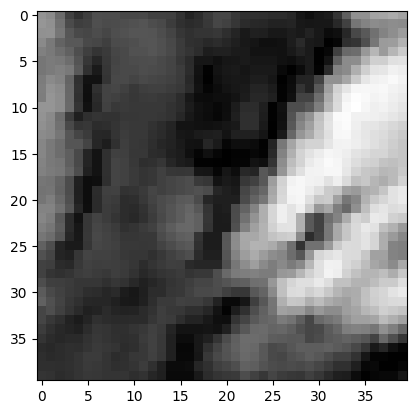

In [484]:
i = 346
plt.imshow(descriptors_low[i][4], cmap='gray')

In [ ]:
# iterate over the scales and plot the corners
plt.subplots(1, scales, figsize=(20, 20))
for i in range(scales):
    print(i, np.sum(corners_arr_high[i] == 1))
    plt.subplot(1, scales, i + 1)
    plt.imshow(corners_arr_high[i], cmap='gray')
    plt.title(f"Scale {i}")

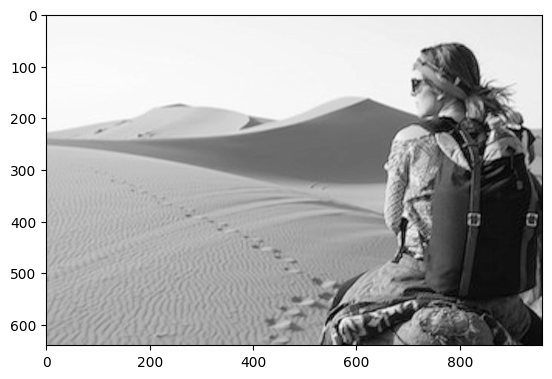

In [432]:
plt.imshow(low_pyramid[1]['G'], cmap='gray')

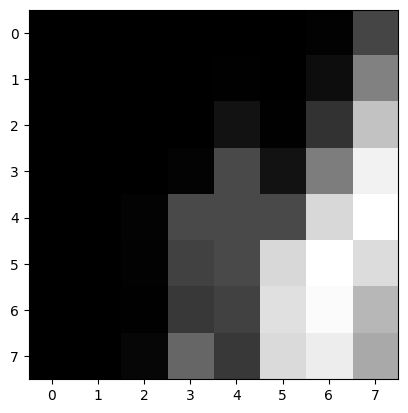

In [34]:
plt.imshow(matches[4][0][4], cmap='gray')

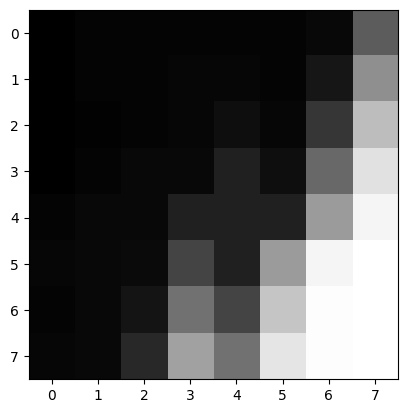

In [33]:
plt.imshow(matches[4][1][4], cmap='gray')

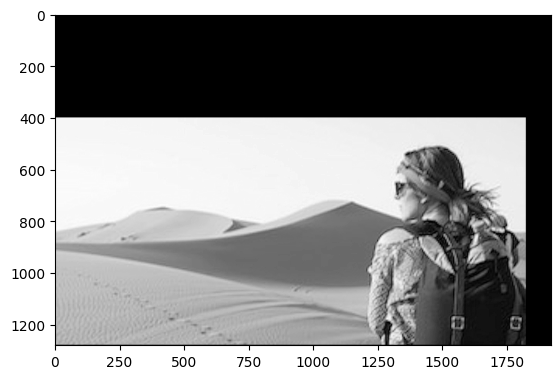

In [231]:
# implementing algorithm for backward warping using bilinear interpolation 
def backward_warping(img, H):
    # Create the inverse transformation matrix
    output_img = np.zeros_like(img)
    # Iterate over the pixels in the output image
    for y in range(output_img.shape[0] -1):
        for x in range(output_img.shape[1] -1):
            # Apply the inverse transformation to the pixel coordinates
            p = np.array([x, y, 1])
            p_prime = np.dot(H, p)
            p_prime = (p_prime / p_prime[2])[:2]
            # Check if the transformed pixel is within the bounds of the input image
            if 0 <= p_prime[0] < img.shape[1] and 0 <= p_prime[1] < img.shape[0]:
                # Perform bilinear interpolation
                x0, y0 = int(p_prime[0]), int(p_prime[1])
                x1, y1 = x0 + 1, y0 + 1
                dx, dy = p_prime[0] - x0, p_prime[1] - y0
                # Perform the interpolation
                try:
                    output_img[y, x] = (1 - dx) * (1 - dy) * img[y0, x0] + dx * (1 - dy) * img[y0, x1] + (1 - dx) * dy * img[y1, x0] + dx * dy * img[y1, x1]
                except:
                    pass
    return output_img





# show the result of backward warping
H = np.array([[1, 0, 100], [0, 1, -400], [0, 0, 1]])
warped_img = backward_warping(img_low_res_gray, H)
plt.imshow(warped_img, cmap='gray')

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

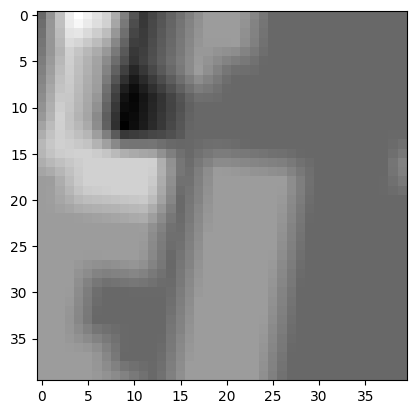

In [95]:
import numpy as np
from scipy.signal import convolve2d

def remove_corners_with_zero_std(corners, window_size):
    # Pad the corners array to handle border cases
    padded_corners = np.pad(corners, window_size // 2, mode='constant')
    
    # Define a kernel for computing the sum of squares of the window
    kernel = np.ones((window_size, window_size))
    
    # Compute the local standard deviation using convolution
    squared_sum = convolve2d(padded_corners**2, kernel, mode='valid')
    sum_squared = convolve2d(padded_corners, kernel, mode='valid')**2 / (window_size**2)
    
    # Set corners with zero standard deviation to zero
    corners_with_std = np.where(squared_sum != sum_squared, corners, 0)
    
    return corners_with_std

# Test the function
corners = np.array([[1, 1, 1, 0, 0, 1],
                    [1, 1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1, 1],
                    [0, 0, 1, 1, 1, 1],
                    [0, 0, 1, 1, 1, 1]])

window_size = 3
result = remove_corners_with_zero_std(corners, window_size)
print("Corners after removal:")
print(result)


Corners after removal:
[[1 1 1 0 0 1]
 [1 0 1 1 1 1]
 [1 1 1 0 0 1]
 [0 0 1 0 0 1]
 [0 0 1 1 1 1]]
